<a href="https://colab.research.google.com/github/specM7/DSGP_Group_33_Brain_Tumor_Predictor/blob/Meningioma_Adrian_2425482/Meningioma_Adrian_2425482.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  AI-Powered Brain Tumor Predictor for Meningioma(Adrian)


## Project Goal
Build a Convolutional Neural Network (CNN) to classify brain MRI images into 4 tumor categories.


## Model Specifications
- **Input**: 224x224 grayscale MRI images
- **Architecture**: Custom CNN with 3 convolutional blocks
- **Output**: 4-class classification (tumor types)
- **Training**: 25 epochs with validation split

##  Project Overview

This project uses a Convolutional Neural Network (CNN) to classify brain MRI images into four tumor categories:
- Glioma
- Meningioma
- Pituitary
- No Tumor

###  Objectives
- Build a robust CNN for MRI classification
- Achieve >90% accuracy on unseen test data
- Provide interpretable visual results


##  Technologies Used
- TensorFlow / Keras
- OpenCV
- NumPy
- Matplotlib & Seaborn


In [ ]:
import os, glob, cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


##  Dataset Upload

Upload the `DataSet.zip` file containing MRI images organized into training and testing folders.


In [ ]:
from google.colab import files

uploaded = files.upload()        # PICK the real DataSet.zip from your PC

zip_name = list(uploaded.keys())[0]
print("Uploaded:", zip_name)

# Unzip into /content/DataSet_raw
!rm -rf /content/DataSet_raw
!mkdir -p /content/DataSet_raw
!unzip -q "$zip_name" -d /content/DataSet_raw

print("\nTop level under /content/DataSet_raw:")
!ls /content/DataSet_raw

print("\nAny 'Training' folders:")
!find /content/DataSet_raw -maxdepth 5 -type d -iname "Training"


Saving DataSet.zip to DataSet.zip
Uploaded: DataSet.zip

Top level under /content/DataSet_raw:
DataSet

Any 'Training' folders:
/content/DataSet_raw/DataSet/Training


##  Set Paths
Look at previous output, find your Training folder path, and paste it in next cell.

Example: `/content/DataSet_raw/DataSet/Training`

In [ ]:

training_path = "/content/DataSet_raw/DataSet/Training"   # example, edit to your real one

raw_root = os.path.dirname(training_path)
print("training_path:", training_path)
print("raw_root:", raw_root)
print("RAW training folders:", os.listdir(training_path))

img_size = (224, 224)
batch_size = 32

train_dir = training_path
test_dir  = os.path.join(raw_root, "Testing")
print("train_dir:", train_dir)
print("test_dir:", test_dir)





training_path: /content/DataSet_raw/DataSet/Training
raw_root: /content/DataSet_raw/DataSet
RAW training folders: ['meningioma', 'pituitary', 'notumor', 'glioma']
train_dir: /content/DataSet_raw/DataSet/Training
test_dir: /content/DataSet_raw/DataSet/Testing


##  Image Preprocessing and Data Augmentation

Data augmentation is applied to improve model generalization and reduce overfitting.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='sparse',
    subset='training',
    seed=42
)

val_ds = val_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='sparse',
    subset='validation',
    seed=42
)

test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='sparse',
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1826 images belonging to 4 classes.


In [ ]:
print("Meningioma class ID:", train_ds.class_indices['meningioma'])

Meningioma class ID: 1


##  Dataset Generators

Keras ImageDataGenerator loads images from directories and creates training, validation, and test datasets.


##  Class Label Mapping

Each tumor class is mapped to a numerical label used during training.


In [ ]:
import os

print("Current working directory:", os.getcwd())
print("\ntrain_dir full path:", train_dir)
print("train_dir exists?", os.path.isdir(train_dir))
if os.path.isdir(train_dir):
    print("Contents of train_dir:", os.listdir(train_dir))
else:
    print("train_dir NOT FOUND – wrong path")

print("\nChecking class folders inside train_dir:")
expected_classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

for cls in expected_classes:
    folder = os.path.join(train_dir, cls)
    exists = os.path.isdir(folder)
    count = len(os.listdir(folder)) if exists else 0
    print(f"  {cls:12}  exists: {exists}   images: {count}")

print("\nSame check for test_dir:")
print("test_dir:", test_dir)
print("test_dir exists?", os.path.isdir(test_dir))
if os.path.isdir(test_dir):
    print("Contents of test_dir:", os.listdir(test_dir))

Current working directory: /content

train_dir full path: /content/DataSet_raw/DataSet/Training
train_dir exists? True
Contents of train_dir: ['meningioma', 'pituitary', 'notumor', 'glioma']

Checking class folders inside train_dir:
  glioma        exists: True   images: 1321
  meningioma    exists: True   images: 1339
  notumor       exists: True   images: 1595
  pituitary     exists: True   images: 1457

Same check for test_dir:
test_dir: /content/DataSet_raw/DataSet/Testing
test_dir exists? True
Contents of test_dir: ['meningioma', 'pituitary', 'notumor', 'glioma']


##  CNN Model Architecture

The CNN consists of multiple convolutional layers followed by fully connected layers.


In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf

model = models.Sequential([
    layers.Input(shape=(224, 224, 1)),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(4, activation='softmax')
])


## Model Compilation & Training

The model is compiled and trained using Adam optimizer and categorical cross-entropy loss.


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,

)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,084,484 (99.50 MB)

 Trainable params: 26,082,500 (99.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 999s 7s/step - accuracy: 0.6378 - loss: 1.0826 - val_accuracy: 0.3339 - val_loss: 1.4180
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 996s 7s/step - accuracy: 0.7720 - loss: 0.6013 - val_accuracy: 0.3094 - val_loss: 3.0484
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 979s 7s/step - accuracy: 0.8184 - loss: 0.4799 - val_accuracy: 0.4645 - val_loss: 2.8573
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 999s 7s/step - accuracy: 0.8288 - loss: 0.4533 - val_accuracy: 0.5083 - val_loss: 1.6407
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 974s 7s/step - accuracy: 0.8533 - loss: 0.4197 - val_accuracy: 0.7257 - val_loss: 0.9637
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 999s 7s/step - accuracy: 0.8624 - loss: 0.3901 - val_accuracy: 0.7195 - val_loss: 0.8546
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 1003s 7s/step - accuracy: 0.8757 - loss: 0.3505 - val_accuracy: 0.7897 - val_loss: 0.7512
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 993s 7s/step - accuracy: 0.8814 - loss: 0.3375 - val_acc

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    filepath="brain_tumor_best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


##  Model Evaluation on Test Data

The model is evaluated on unseen test data to measure real-world performance.


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


58/58 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8252 - loss: 0.6623
Test Accuracy: 0.8400876522064209


## Training vs Validation Accuracy

This plot compares training and validation accuracy across epochs.


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


##  Confusion Matrix

The confusion matrix visualizes classification performance across tumor classes.


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

y_true = test_ds.classes
y_pred = np.argmax(model.predict(test_ds), axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=train_ds.class_indices.keys(),
    yticklabels=train_ds.class_indices.keys()
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


##  Save & Download Model

The trained model is saved and downloaded for future use.


In [ ]:
model.save("brain_tumor_mri_model.h5")


##Add Detailed Evaluation Metrics

In [ ]:
from sklearn.metrics import classification_report

target_names = list(train_ds.class_indices.keys())

print(classification_report(
    y_true,
    y_pred,
    target_names=target_names
))


              precision    recall  f1-score   support

      glioma       0.75      0.99      0.85       300
  meningioma       1.00      0.66      0.79       821
     notumor       0.81      0.98      0.89       405
   pituitary       0.75      1.00      0.86       300

    accuracy                           0.84      1826
   macro avg       0.83      0.91      0.85      1826
weighted avg       0.88      0.84      0.83      1826



##Compute ROC & AUC

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


##Prepare Labels (One-vs-Rest)

In [ ]:
n_classes = len(target_names)

y_true_bin = label_binarize(y_true, classes=range(n_classes))
y_pred_prob = model.predict(test_ds)


58/58 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step


##Plot ROC Curve (Focus on MENINGIOMA)

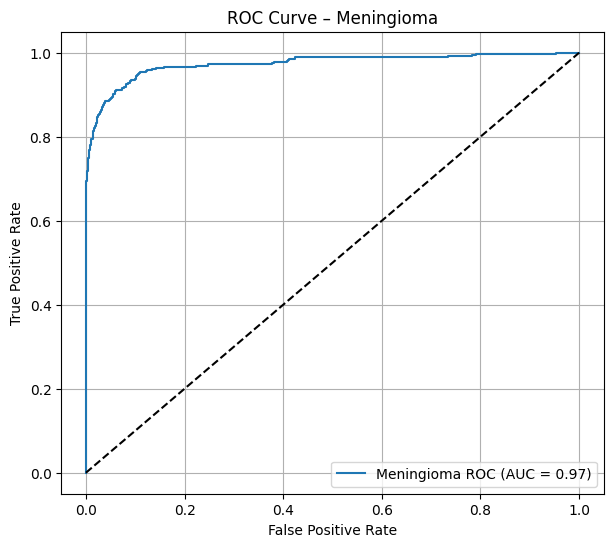

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7,6))
plt.plot(
    fpr[train_ds.class_indices['meningioma']],
    tpr[train_ds.class_indices['meningioma']],
    label=f"Meningioma ROC (AUC = {roc_auc[train_ds.class_indices['meningioma']]:.2f})"
)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Meningioma")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

report_dict = classification_report(
    y_true,
    y_pred,
    target_names=target_names,
    output_dict=True
)

df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv("classification_report.csv")

print("Saved classification_report.csv")


Saved classification_report.csv


In [ ]:
!ls /content


brain_tumor_mri_model.h5   DataSet_raw	sample_data
classification_report.csv  DataSet.zip	Te-no_0011.jpg


In [ ]:
from google.colab import files

uploaded = files.upload()


Saving Te-gl_0016.jpg to Te-gl_0016.jpg


In [ ]:
img_path = "Te-gl_0016.jpg"


In [ ]:
import os
print(os.path.exists(img_path))


True


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Predicted Class: glioma
Confidence: 0.9999945


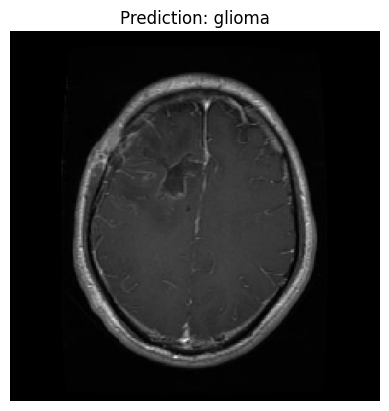

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img = image.load_img(
    img_path,
    target_size=(224, 224),
    color_mode="grayscale"
)

img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
pred_class = np.argmax(pred)

class_names = list(train_ds.class_indices.keys())

print("Predicted Class:", class_names[pred_class])
print("Confidence:", np.max(pred))

plt.imshow(img_array[0].squeeze(), cmap="gray")
plt.title(f"Prediction: {class_names[pred_class]}")
plt.axis("off")
plt.show()
